In [1]:
%matplotlib inline  
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from matplotlib import pylab
import pickle
import numpy

# <center> Word Embedding </center>
## <center> And Mulitilingual Transformation Matrix </center>

### 1. Word Embedding


In [2]:
sentences = ["there were doors all round the hall",  
             "the doors were locked", 
             "Alice opened the doors"]

vocab = set(" ".join(sentences).split())
vocab_size = len(vocab)
print vocab

set(['all', 'locked', 'opened', 'there', 'Alice', 'hall', 'doors', 'were', 'the', 'round'])


> <i> In a nutshell, Word Embedding turns text into numbers... </i>

In [3]:
'''
    Bag-of-word also map words to numbers?!
'''
word2int = {}
int2word = {}
for i, word in enumerate(vocab):
    word2int[word] = i
    int2word[i] = word
    
for word in word2int:
    print word, "->", word2int[word]


all -> 0
locked -> 1
opened -> 2
there -> 3
Alice -> 4
round -> 9
doors -> 6
were -> 7
the -> 8
hall -> 5


> <i> ... which preserves the contextual similarity of words </i>

<img src="skipgram_cbow.png" width=700 />

### Skip-gram model

#### Training data:

In [4]:
'''
    Create word pairs from sentences to train the word embedding model
'''

WINDOW_SIZE = 2

def get_word_pairs(sentences):
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for i, word in enumerate(sentence):
            for nb_word in sentence[max(i - WINDOW_SIZE, 0) : min(i + WINDOW_SIZE, len(sentence)) + 1] : 
                if nb_word != word:
                    data.append([word, nb_word])
                    
    return data

In [5]:
data = get_word_pairs(sentences)
print data [:5]

[['there', 'were'], ['there', 'doors'], ['were', 'there'], ['were', 'doors'], ['were', 'all']]


In [6]:
'''
    Using one-hot vector to represent word
'''
def to_one_hot(data_point_index):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [7]:
'''
    Convert all word pairs to training data
'''
x_train = []
y_train = []
for d in data:
    x_train.append(to_one_hot(word2int[ d[0] ]))
    y_train.append(to_one_hot(word2int[ d[1] ]))

print x_train[0]
print y_train[0]

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


#### Model structure: 
<img src = "skipgram_model.png" width=500px/>

<center> Using a simple neural network with single hidden layer </center>

In [8]:
'''
    Define the tensorflow graph
'''
EMBEDDING_DIM = 10

x = tf.placeholder(tf.float32, shape=(None, vocab_size))
y_label = tf.placeholder(tf.float32, shape=(None, vocab_size))

W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM]))
hidden_layer = tf.add(tf.matmul(x,W1), b1)

W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

In [9]:
'''
    Define loss and optimizer function
'''
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)


#### Train the model

In [10]:
'''
    Train the model
'''

sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)


N_INTERS = 100

for i in range(N_INTERS):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})
    if (i%10 == 9):
        print'loss after',i + 1,"inters is", sess.run(cross_entropy_loss, feed_dict={x: x_train, y_label: y_train})

loss after 10 inters is 3.07665
loss after 20 inters is 2.44711
loss after 30 inters is 2.22757
loss after 40 inters is 2.0934
loss after 50 inters is 1.99177
loss after 60 inters is 1.91084
loss after 70 inters is 1.84603
loss after 80 inters is 1.79451
loss after 90 inters is 1.75398
loss after 100 inters is 1.72221


In [11]:
'''
    Ignore the output layer, 
    The hidden layer is the embedding layer
'''
vectors = sess.run(W1 + b1)
print vectors.shape

(10, 10)


In [12]:
for word in vocab:
    print word
    print vectors[ word2int[word] ]
    print

all
[ 1.15325248  2.32830691  0.88257879 -1.05258369  0.2037687   0.27326888
 -0.40758994 -1.04274035 -0.30766195  0.36388719]

locked
[ 1.40618181  0.30837959  0.31995952 -1.1423595  -1.32939148  0.00591129
 -0.54765069 -0.18301542  0.29685831  2.18362355]

opened
[ 1.58108675  0.3053236   0.46392071  1.08006358  0.36515734 -0.93649858
 -1.98916733 -0.12947674  0.60217428  2.90212393]

there
[-0.43040216 -0.26353312  2.62229562 -1.01138484 -1.21997023  0.33608133
 -0.31985635 -0.357467    1.68941271  1.45645642]

Alice
[ 1.93662667  2.87596583  0.9731921  -0.63943934 -0.59984159 -0.49551082
 -0.47912347 -1.72818434 -1.03513277  1.23922145]

hall
[ 1.21532965  1.03534734  4.89960432  0.56908977  0.71194053 -1.75483024
 -1.4971776  -1.38733923 -0.86824548  1.45876241]

doors
[ 0.81412667  1.11824155  2.07449007 -0.80013084 -0.577739   -0.9600513
 -0.13478574 -0.29242915 -0.58093357  0.61940372]

were
[  9.65003908e-01  -4.69385982e-01   8.53516400e-01   5.91870248e-02
   1.33427382e-02 

In [13]:
'''
    Calculate Eclidean distance of two words
'''

def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

In [14]:
print 'doors', (int2word[find_closest(word2int['doors'], vectors)])

doors round


In [34]:
'''
    Transform the embedding vector to present in 2D 
'''
def get_2D_vector(vectors):
    tsne = TSNE(perplexity=100, n_components=2, init='pca', n_iter=1000)
    return tsne.fit_transform(vectors)
def plot(embeddings, labels):
    pylab.figure(figsize=(5,5))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()
    

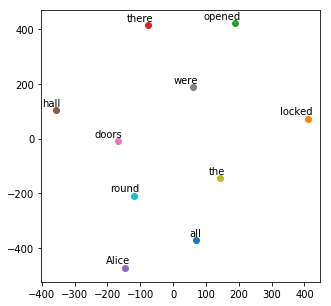

In [35]:
plot(get_2D_vector(vectors), vocab)

### Speeding things up: 
- Mini-batch training
    - Cost function is averaged over a small number of samples, from around 10-500
    - Smooths out some of the noise in SGD
    - Still allowing the “kick” out of local minimums of the cost function
    - Mini-batch size is small, so speeds up the training process
    
    
- Noise Contrastive Estimation (NCE)
    - Randomly samples 2-20 possible context words to evaluates the probability
    - Perform well and drastically speeds up the training process
    - <i><b> tf.nn.nce_loss() </b></i>
    
http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/

http://ruder.io/word-embeddings-1/index.html

### Pretrained model

http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

In [17]:
'''
    Load pretrained model (English)
'''
en_vocabs, en_embeddings = pickle.load(open('polyglot-en.pkl', 'rb'))
print("Emebddings shape is {}".format(en_embeddings.shape))

Emebddings shape is (100004, 64)


In [18]:
'''
    Get a subset of embeddings to display
'''
def get_sub_embedding(vocabs, embeddings, words):
    sub_embeddings = [[]] * len(words)
    for i in range(len(vocabs)):
        if vocabs[i] in words:
            sub_embeddings[words.index(vocabs[i])] = embeddings[i]
            
    return sub_embeddings


In [19]:
sub_en_vocabs = ["two", "six", "nine", "ten",
                 "dog", "cat", "cow", "bird"]

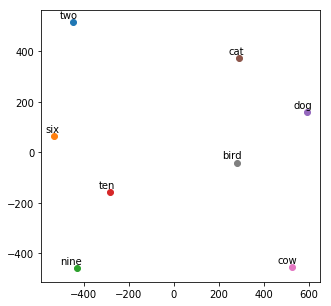

In [21]:
sub_en_embeddings = get_sub_embedding(en_vocabs, en_embeddings, sub_en_vocabs)
plot(get_2D_vector(sub_en_embeddings), sub_en_vocabs)

### 2. Multilingual Transformation Matrix


https://static.googleusercontent.com/media/research.google.com/vi//pubs/archive/44931.pdf

We need:
- Monolingual models of languages
- Bilingual dictionary to learn a linear projection between the languages

In [22]:
'''
    Load pretrained model (Vietnamese)
'''
vi_vocabs, vi_embeddings = pickle.load(open('vi.pkl', 'rb'))
print("Emebddings shape is {}".format(vi_embeddings.shape))

Emebddings shape is (292168, 300)


In [23]:
sub_vi_vocabs = ["hai", "sáu", "chín", "mười",
                 "chó", "mèo", "bò", "chim"]

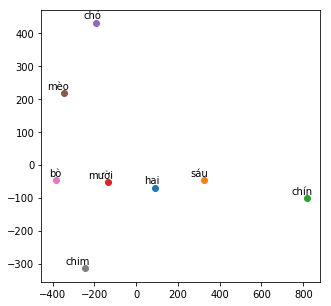

In [24]:
sub_vi_embeddings = get_sub_embedding(vi_vocabs, vi_embeddings, sub_vi_vocabs)
sub_vi_vocabs = [s.decode("utf-8") for s in sub_vi_vocabs]
plot(get_2D_vector(sub_vi_embeddings), sub_vi_vocabs)

> <i>Transform one language's vector space into the space of another simply by utilising a linear projection with a transformation matrix W </i>

In [26]:
'''
    Define the tensorflow graph
'''
bi_vocab_size = len(sub_vi_vocabs)
en_emb_size = en_embeddings.shape[1]
vi_emb_size = vi_embeddings.shape[1]

bi_x = tf.placeholder(tf.float32, shape=(None, vi_emb_size))
bi_y_label = tf.placeholder(tf.float32, shape=(None, en_emb_size))

bi_W1 = tf.Variable(tf.random_normal([vi_emb_size, en_emb_size]))
bi_prediction = tf.matmul(bi_x, bi_W1)

In [27]:
'''
    Define loss and optimizer function
'''

bi_cross_entropy_loss = tf.reduce_mean((bi_prediction - bi_y_label)**2)
bi_train_step = tf.train.GradientDescentOptimizer(0.1).minimize(bi_cross_entropy_loss)


In [28]:
'''
    Train the model
'''

sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)


N_INTERS = 10000

for i in range(N_INTERS):
    temp_vi = [sub_vi_embeddings[i%bi_vocab_size]]
    temp_en = [sub_en_embeddings[i%bi_vocab_size]]
    sess.run(bi_train_step, feed_dict={bi_x: temp_vi, bi_y_label: temp_en})
    if (i%1000 == 999):
        print'loss after',i + 1,"inters is", sess.run(bi_cross_entropy_loss, feed_dict={bi_x: temp_vi, bi_y_label: temp_en})

loss after 1000 inters is 0.000892327
loss after 2000 inters is 0.000138546
loss after 3000 inters is 2.66746e-05
loss after 4000 inters is 5.2337e-06
loss after 5000 inters is 1.02802e-06
loss after 6000 inters is 2.01913e-07
loss after 7000 inters is 3.97819e-08
loss after 8000 inters is 8.07523e-09
loss after 9000 inters is 1.7893e-09
loss after 10000 inters is 5.18266e-10


In [29]:
vi_to_en_vectors = sess.run(tf.matmul(bi_x, bi_W1), feed_dict={bi_x: sub_vi_embeddings})

In [30]:
for i in range(bi_vocab_size):
    print sub_en_vocabs[i], sub_vi_vocabs[i], euclidean_dist(sub_en_embeddings[i],vi_to_en_vectors[i])

two hai 0.00138547
six sáu 0.00274734
nine chín 6.38929e-05
ten mười 0.00175956
dog chó 0.000135697
cat mèo 0.000112904
cow bò 0.000139622
bird chim 0.00018393


English Embeddings


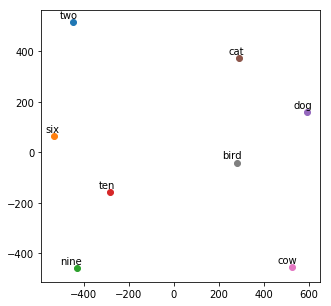

Vietnamese Embeddings


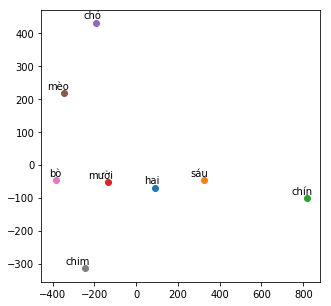

Vietnamese Embeddings in English's vector space


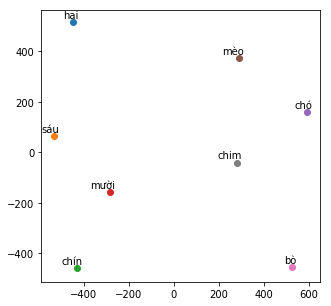

In [38]:
print "English Embeddings"
plot(get_2D_vector(sub_en_embeddings), sub_en_vocabs)

print "Vietnamese Embeddings"
plot(get_2D_vector(sub_vi_embeddings), sub_vi_vocabs)

print "Vietnamese Embeddings in English's vector space"
plot(get_2D_vector(vi_to_en_vectors), sub_vi_vocabs)

### 3. Using Word Embedding in Text Classification

Calculate the feature vector of documents:
- Sum of word vectors
- Average of word vectors
- Average of word vectors with weight (such as tf-idf)

So, for multilingual problem:
- Training the classifier on source language (English)
- Use the classifier to classify target language (Vietnamese) by mapping the vector of target word to source's vector space 